In [1]:
import numpy as np

### RNNレイヤの実装

In [3]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

### Time RNNレイヤの実装

In [5]:
class TimeRNN:
    def _init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_lile(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful
    
    def set_state(self, h):
        self.h = h
    
    def reset_state(self):
        self.h = None
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros_like((N, H), dtype='f')
        
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        df = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh) # 合算した勾配
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

### RNNLMの実装

In [7]:
import time_layers

In [8]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            time_layers.TimeEmbedding(embed_W),
            time_layers.TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            time_layers.TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = time_layers.TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

### RNNLMの学習コード

In [9]:
class SGD:
    '''
    確率的勾配降下法（Stochastic Gradient Descent）
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

In [10]:
import ptb
import matplotlib.pyplot as plt

In [11]:
# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNNの隠れ状態ベクトルの要素数
time_size = 5 # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] # 入力
ts = corpus[1:] # 出力（教師データ）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ①ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ②ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    
    # ③エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f' % (epoch + 1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

Done
corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 392.22
| epoch 2 | perplexity 269.36
| epoch 3 | perplexity 227.48
| epoch 4 | perplexity 216.70
| epoch 5 | perplexity 207.04
| epoch 6 | perplexity 202.92
| epoch 7 | perplexity 199.85
| epoch 8 | perplexity 197.37
| epoch 9 | perplexity 191.51
| epoch 10 | perplexity 193.10
| epoch 11 | perplexity 189.27
| epoch 12 | perplexity 192.82
| epoch 13 | perplexity 191.10
| epoch 14 | perplexity 190.18
| epoch 15 | perplexity 189.94
| epoch 16 | perplexity 186.34
| epoch 17 | perplexity 184.27
| epoch 18 | perplexity 181.55
| epoch 19 | perplexity 182.50
| epoch 20 | perplexity 184.48
| epoch 21 | perplexity 182.25
| epoch 22 | perplexity 177.52
| epoch 23 | perplexity 176.67
| epoch 24 | perplexity 176.90
| epoch 25 | perplexity 173.71
| epoch 26 | perplexity 174.20
| epoch 27 | perplexity 170.66
| epoch 28 | perplexity 168.75
| epoch 29 | perplexity 164.35
| epoch 30 | perplexity 159.36
| epoch 31 | perplexity 162.13
| e

### RNNLMのTrainerクラス

In [13]:
import trainer

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 417.20
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 351.95
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 249.46
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 217.88
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 209.09
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 207.21
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 200.75
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 200.51
| epoch 9 |  iter 1 / 19 | time 1[s] | perplexity 194.51
| epoch 10 |  iter 1 / 19 | time 1[s] | perplexity 190.54
| epoch 11 |  iter 1 / 19 | time 1[s] | perplexity 192.68
| epoch 12 |  iter 1 / 19 | time 1[s] | perplexity 190.13
| epoch 13 |  iter 1 / 19 | time 1[s] | perplexity 193.30
| epoch 14 |  iter 1 / 19 | time 1[s] | perplexity 187.02
| epoch 15 |  iter 1 / 19 | time 1[s] | perplexity 187.16
| epoch 16 |  iter 1 / 19 | time 1[s] | perplexity 191.56
| epoch 17 |  iter 1 / 19 | time 1[s] | perplexity 189.68
| epoch 18 |  iter 1 / 

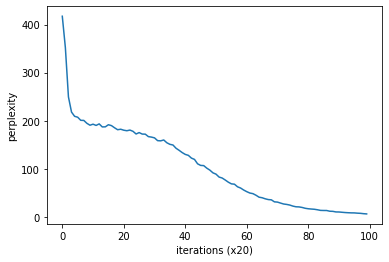

In [14]:
# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 5  # RNNを展開するサイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # テスト用にデータセットを小さくする
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = trainer.RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()